### These functions comes from Isnensee solution for preprocessing data, it saves them as a pickle file

Single pickle file contains 4 images for a patient: end-systole, end-systole segmented, end-diastole, end-diastole segmented.

in file patient_info.cfg there is a dictionary with key information on patient weight, height and diastol,systole frames

In [2]:
import torch
import numpy as np
import SimpleITK as sitk
import os
from multiprocessing import pool
import pickle
import numpy as np
from skimage.transform import resize
ids_pats = 101

In [3]:
# source -> https://github.com/MIC-DKFZ/ACDC2017
def resize_image(image, old_spacing, new_spacing, order=3):
    new_shape = (int(np.round(old_spacing[0]/new_spacing[0]*float(image.shape[0]))),
                 int(np.round(old_spacing[1]/new_spacing[1]*float(image.shape[1]))),
                 int(np.round(old_spacing[2]/new_spacing[2]*float(image.shape[2]))))
    return resize(image, new_shape, order=order, mode='edge')

str_to_ind = {'DCM':0, 'HCM':1, 'MINF':2, 'NOR':3, 'RV':4}
ind_to_str = {}
for k in str_to_ind.keys():
    ind_to_str[str_to_ind[k]] = k

# source -> https://github.com/MIC-DKFZ/ACDC2017
def view_patient_raw_data(patient, width=400, height=400):
    import batchviewer
    a = []
    a.append(patient['ed_data'][None])
    a.append(patient['ed_gt'][None])
    a.append(patient['es_data'][None])
    a.append(patient['es_gt'][None])
    batchviewer.view_batch(np.vstack(a), width, height)

In [4]:
# source -> https://github.com/MIC-DKFZ/ACDC2017
def convert_to_one_hot(seg):
    vals = np.unique(seg)
    res = np.zeros([len(vals)] + list(seg.shape), seg.dtype)
    for c in range(len(vals)):
        res[c][seg == c] = 1
    return res

# source -> https://github.com/MIC-DKFZ/ACDC2017
def preprocess_image(itk_image, is_seg=False, spacing_target=(1, 0.5, 0.5), keep_z_spacing=False):
    spacing = np.array(itk_image.GetSpacing())[[2, 1, 0]]
    image = sitk.GetArrayFromImage(itk_image).astype(float)
    if keep_z_spacing:
        spacing_target = list(spacing_target)
        spacing_target[0] = spacing[0]
    if not is_seg:
        order_img = 3
        if not keep_z_spacing:
            order_img = 1
        image = resize_image(image, spacing, spacing_target, order=order_img).astype(np.float32)
        image -= image.mean()
        image /= image.std()
    else:
        tmp = convert_to_one_hot(image)
        vals = np.unique(image)
        results = []
        for i in range(len(tmp)):
            results.append(resize_image(tmp[i].astype(float), spacing, spacing_target, 1)[None])
        image = vals[np.vstack(results).argmax(0)]
    return image

In [21]:
# source -> https://github.com/MIC-DKFZ/ACDC2017
ids_pats = 101
def load_dataset(ids=range(ids_pats), root_dir="./results/"):
    with open(os.path.join(root_dir, "patient_info.pkl"), 'rb') as f:
        patient_info = pickle.load(f)

    data = {}
    for i in ids:
        if os.path.isfile(os.path.join(root_dir, "pat_%03.0d.npy"%i)):
            a = np.load(os.path.join(root_dir, "pat_%03.0d.npy"%i), mmap_mode='r')
            data[i] = {}
            data[i]['height'] = patient_info[i]['height']
            data[i]['weight'] = patient_info[i]['weight']
            data[i]['pathology'] = patient_info[i]['pathology']
            data[i]['ed_data'] = a[0, :]
            data[i]['ed_gt'] = a[1, :]
            data[i]['es_data'] = a[2, :]
            data[i]['es_gt'] = a[3, :]
    return data

# source -> https://github.com/MIC-DKFZ/ACDC2017
def process_patient(args):
    id, patient_info, folder, folder_out, keep_z_spc = args
    #print id
    # if id in [286, 288]:
    #     return
    patient_folder = os.path.join(folder, "patient%03.0d"%id)
    if not os.path.isdir(patient_folder):
        return
    images = {}

    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (id, patient_info[id]['ed']))
    if os.path.isfile(fname):
        images["ed"] = sitk.ReadImage(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (id, patient_info[id]['ed']))
    if os.path.isfile(fname):
        images["ed_seg"] = sitk.ReadImage(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (id, patient_info[id]['es']))
    if os.path.isfile(fname):
        images["es"] = sitk.ReadImage(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (id, patient_info[id]['es']))
    if os.path.isfile(fname):
        images["es_seg"] = sitk.ReadImage(fname)

    print (id, images["es_seg"].GetSpacing())

    for k in images.keys():
        #print k
        images[k] = preprocess_image(images[k], is_seg=(k == "ed_seg" or k == "es_seg"),
                                     spacing_target=(10, 1.25, 1.25), keep_z_spacing=keep_z_spc)

    img_as_list = []
    for k in ['ed', 'ed_seg', 'es', 'es_seg']:
        if k not in images.keys():
            print (id, "has missing key:", k)
        img_as_list.append(images[k][None])
    try:
        all_img = np.vstack(img_as_list)
    except:
        print (id, "has a problem with spacings")
    np.save(os.path.join(folder_out, "pat_%03.0d" % id), all_img.astype(np.float32))

In [22]:
# source -> https://github.com/MIC-DKFZ/ACDC2017
def generate_patient_info(folder):
    patient_info={}
    for id in range(ids_pats):
        fldr = os.path.join(folder, 'patient%03.0d'%id)
        if not os.path.isdir(fldr):
            print ("could not find dir of patient ", id)
            continue
        nfo = np.loadtxt(os.path.join(fldr, "Info.cfg"), dtype=str, delimiter=': ')
        
        patient_info[id] = {}
        patient_info[id]['ed'] = int(nfo[0, 1])
        patient_info[id]['es'] = int(nfo[1, 1])
        patient_info[id]['height'] = float(nfo[3, 1])
        patient_info[id]['pathology'] = nfo[2, 1]
        patient_info[id]['weight'] = float(nfo[4, 1])
    return patient_info

# source -> https://github.com/MIC-DKFZ/ACDC2017
def run_preprocessing(folder="./ACDC/training/",
                      folder_out = "./results/", keep_z_spacing=True):
    patient_info = generate_patient_info(folder)

    if not os.path.isdir(folder_out):
        os.mkdir(folder_out)
    with open(os.path.join(folder_out, "patient_info.pkl"), 'wb') as f:
        pickle.dump(patient_info, f)

    # beware of z spacing!!! see process_patient for more info!
    ids = range(ids_pats)
    p = pool.Pool(8)
    p.map(process_patient, zip(ids, [patient_info]*ids_pats, [folder]*ids_pats, [folder_out]*ids_pats, [keep_z_spacing]*ids_pats))
    p.close()
    p.join()

In [25]:
x = load_dataset()
sizes_es = []
sizes_ed = []
for i in x:
    try:
        sizes_es.append(np.shape(x[i]['es_data'])[0])
        sizes_ed.append(np.shape(x[i]['ed_data'])[0])
    except:
        pass

In [29]:
print(np.median(sizes_es))
print(np.median(sizes_ed))

9.0
9.0


In [53]:
run_preprocessing('../mri-example-data/training/','./results',True)

could not find dir of patient  0
8 (1.5625, 1.5625, 10.0)
24 (1.5625, 1.5625, 10.0)
1 (1.5625, 1.5625, 10.0)
28 (1.5625, 1.5625, 10.0)
12 (1.5625, 1.5625, 10.0)
16 (1.4453099966049194, 1.4453099966049194, 10.0)
4 (1.3671875, 1.3671875, 10.0)
20 (1.7578099966049194, 1.7578099966049194, 10.0)
25 (1.3671875, 1.3671875, 10.0)
17 (1.5625, 1.5625, 10.0)
5 (1.40625, 1.40625, 10.0)
13 (1.4453099966049194, 1.4453099966049194, 10.0)
21 (1.6796875, 1.6796875, 10.0)
9 (1.3671900033950806, 1.3671900033950806, 10.0)
29 (1.3671875, 1.3671875, 10.0)
2 (1.3671875, 1.3671875, 10.0)
26 (1.3671875, 1.3671875, 10.0)
18 (1.3671900033950806, 1.3671900033950806, 10.0)
30 (1.4453125, 1.4453125, 10.0)
10 (1.5625, 1.5625, 10.0)
6 (1.7578125, 1.7578125, 10.0)
14 (1.3671900033950806, 1.3671900033950806, 10.0)
3 (1.5625, 1.5625, 10.0)
22 (1.40625, 1.40625, 10.0)
19 (1.4453099966049194, 1.4453099966049194, 10.0)
27 (1.3671875, 1.3671875, 10.0)
31 (1.484375, 1.484375, 10.0)
15 (1.3671900033950806, 1.3671900033950806,

### Load data and see what's inside

In [7]:
with open('results/patient_info.pkl', 'rb') as f:
    data = np.loads(f.read())
    print(data)

{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 30.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 30.0}, 3: {'ed': 1, 'es': 15, 'height': 165.0, 'pathology': 'DCM', 'weight': 30.0}, 4: {'ed': 1, 'es': 15, 'height': 159.0, 'pathology': 'DCM', 'weight': 28.0}, 5: {'ed': 1, 'es': 13, 'height': 165.0, 'pathology': 'DCM', 'weight': 30.0}, 6: {'ed': 1, 'es': 16, 'height': 180.0, 'pathology': 'DCM', 'weight': 28.0}, 7: {'ed': 1, 'es': 7, 'height': 173.0, 'pathology': 'DCM', 'weight': 16.0}, 8: {'ed': 1, 'es': 13, 'height': 180.0, 'pathology': 'DCM', 'weight': 28.0}, 9: {'ed': 1, 'es': 13, 'height': 153.0, 'pathology': 'DCM', 'weight': 35.0}, 10: {'ed': 1, 'es': 13, 'height': 170.0, 'pathology': 'DCM', 'weight': 28.0}, 11: {'ed': 1, 'es': 8, 'height': 180.0, 'pathology': 'DCM', 'weight': 15.0}, 12: {'ed': 1, 'es': 13, 'height': 160.0, 'pathology': 'DCM', 'weight': 30.0}, 13: {'ed': 1, 'es': 14, 'height': 175.0, 'pathology': 'DCM', 'weight': 30.

/home/adri/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.loads is deprecated, use pickle.loads instead
  


In [1]:
import os
import numpy as np
def load_concepts_dataset(root_dir="./concepts/"):

    data = {}
    dirs = os.listdir(root_dir)
    patients = {int(x.split('_')[0].strip('patient')):x for x in dirs}
    
    for i, x in patients.items():
        a = np.load(os.path.join(root_dir, x), mmap_mode='r')
        data[i] = {}
        data[i]['pathology'] = x.split('_')[-1].split('.')[0]
        data[i]['segments'] = a
    return data

In [2]:
x = load_concepts_dataset()

In [13]:
print(len(x[40]['pathology']))
print(np.shape(x[40]['segments']))
print(x[40]['pathology'])

3
(30, 25)
HCM


In [3]:
x

{40: {'pathology': 'HCM',
  'segments': memmap([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.,

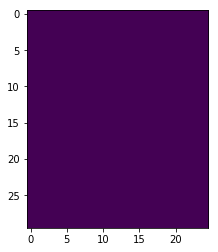

In [19]:
import matplotlib.pyplot as plt
plt.imshow(x[40]['segments'])

In [2]:
dirs = ['patient40_patches_30segments_0_path_HCM.npy',   'patient83_patches_30segments_0_path_RV.npy','patient41_patches_30segments_0_path_MINF.npy']
patients = [int(x.split('_')[0].strip('patient')) for x in dirs]
patients

[40, 83, 41]

In [8]:
data = load_dataset()

In [9]:
data[1].keys()

dict_keys(['height', 'weight', 'pathology', 'ed_data', 'ed_gt', 'es_data', 'es_gt'])

### See the size of data for identified event of end-diastole (it contains 8 short axis images)

In [10]:
view_patient_raw_data(data[1])

AttributeError: 'int' object has no attribute 'shape'

In [11]:
np.shape(data[19]['es_data'])

(11, 296, 250)

In [12]:
np.shape(data[100]['ed_data'])

(8, 320, 227)

### Plot an example image

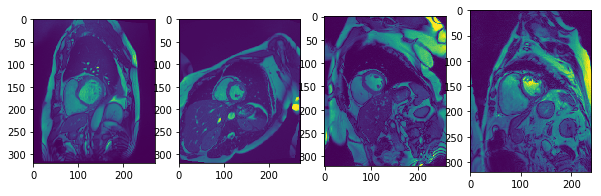

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,12))
plt.subplot(3,4,1)
plt.imshow(data[1]['ed_data'][1])
plt.subplot(3,4,2)
plt.imshow(data[69]['ed_data'][1])
plt.subplot(3,4,3)
plt.imshow(data[70]['ed_data'][1])
plt.subplot(3,4,4)
plt.imshow(data[86]['ed_data'][1])

plt.show()

(10, 320, 270)


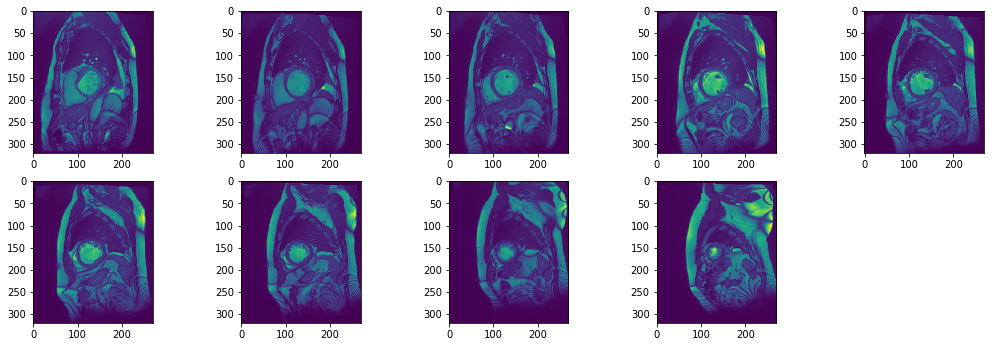

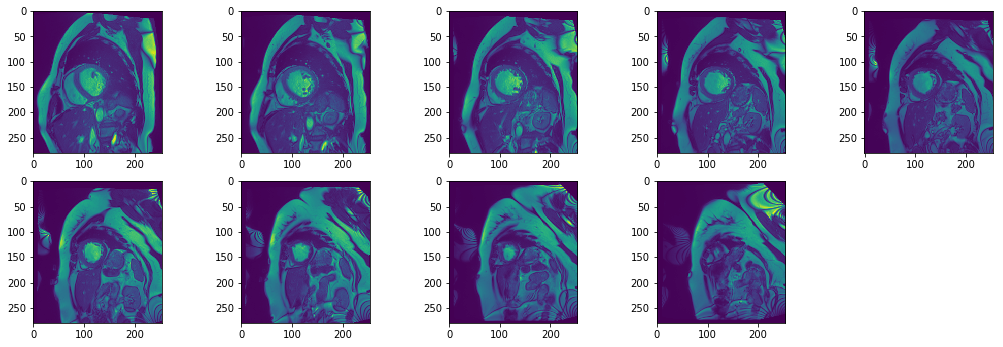

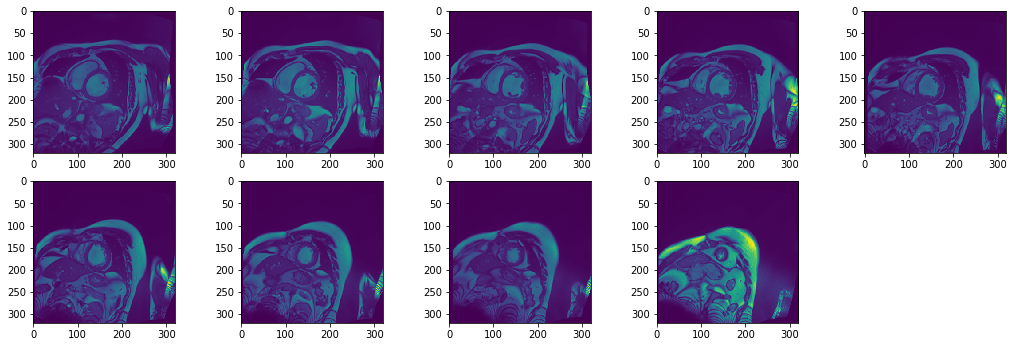

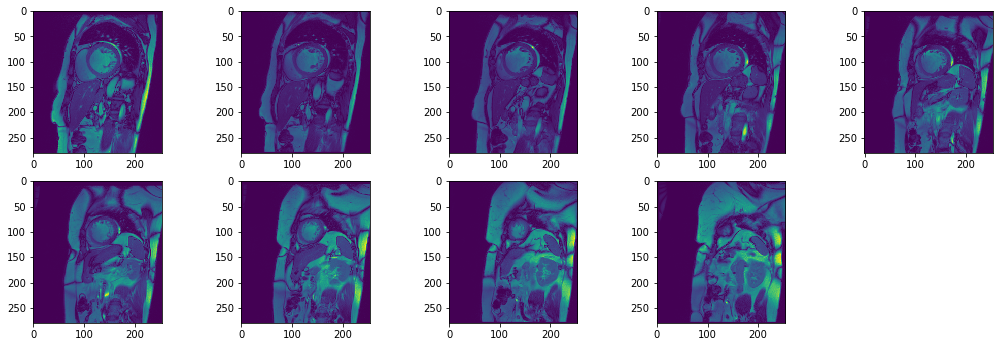

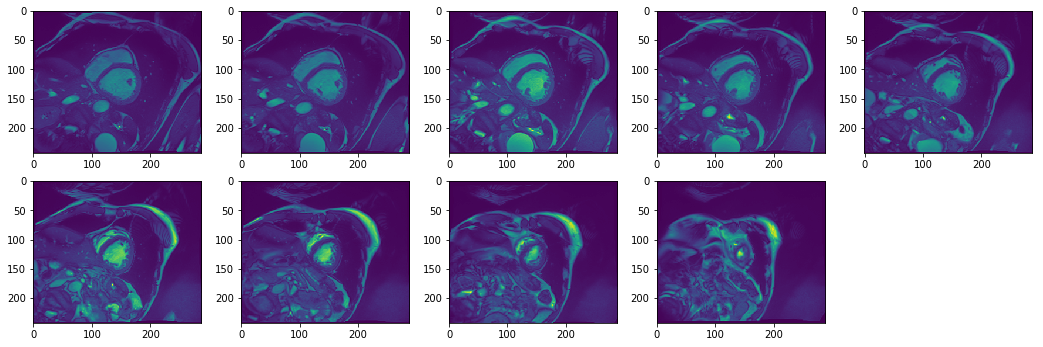

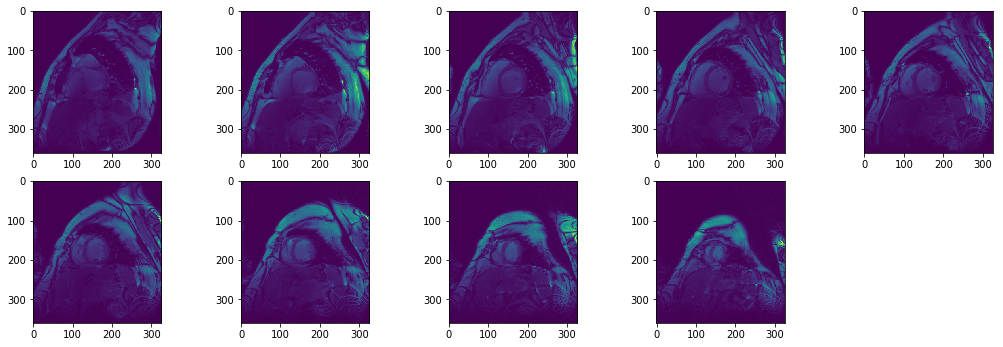

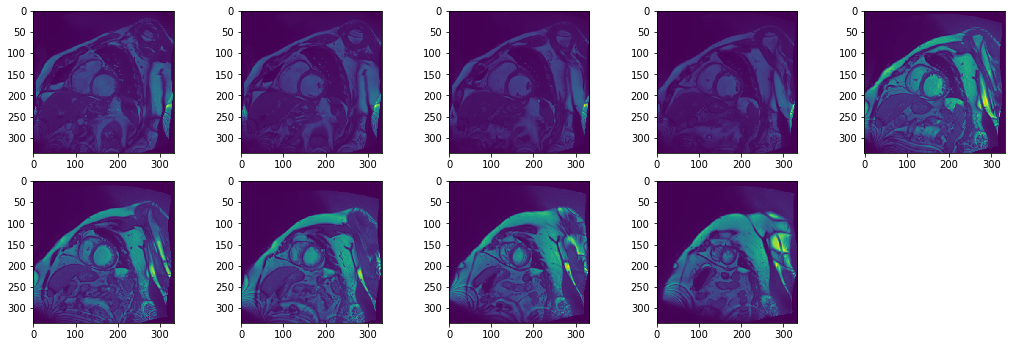

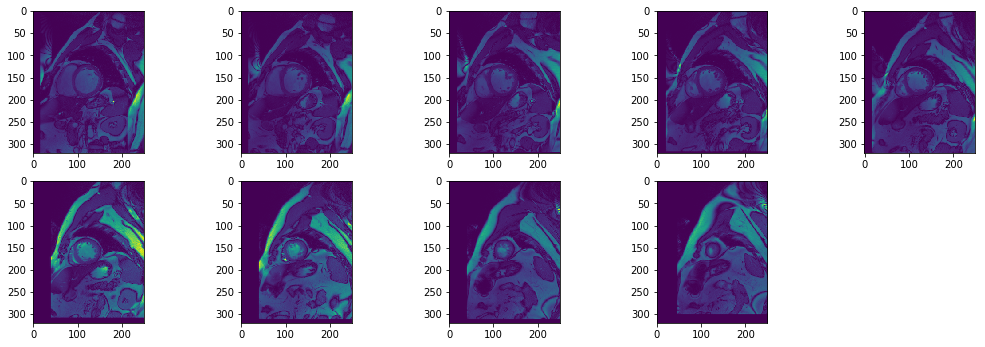

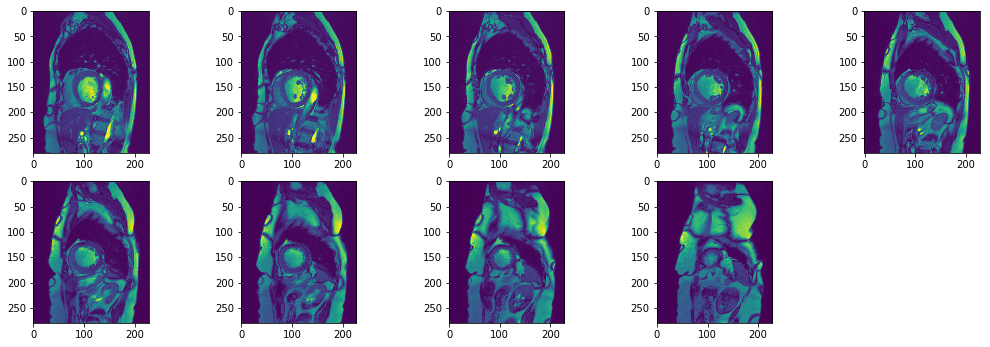

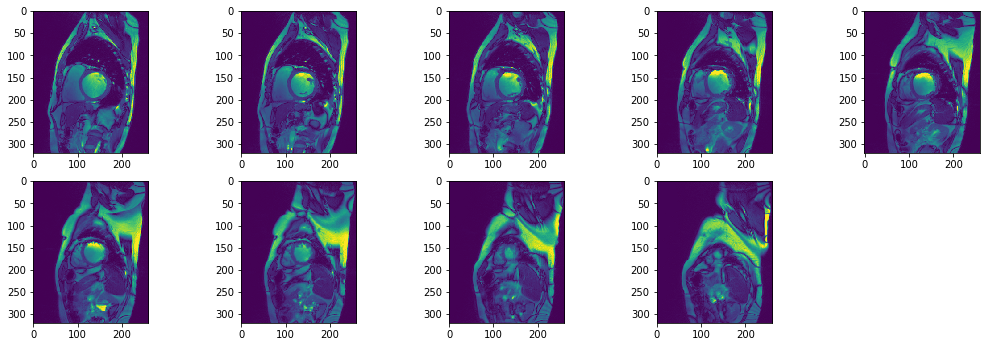

In [26]:
import matplotlib.pyplot as plt

s = np.shape(data[1]['ed_data'])
print(s)

for j in range(1,11):
    plt.figure(figsize=(18,12))
    for i in range(1,s[0]):
        plt.subplot(4,5,i)
        plt.imshow(data[j]['ed_data'][i])

    plt.show()

(552960,)

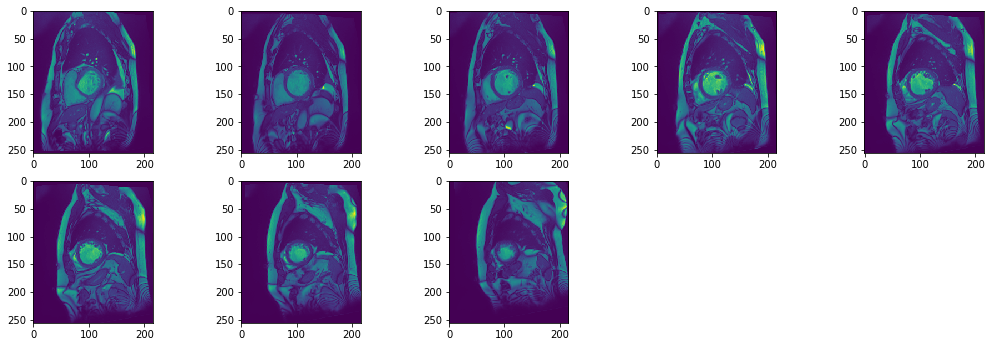

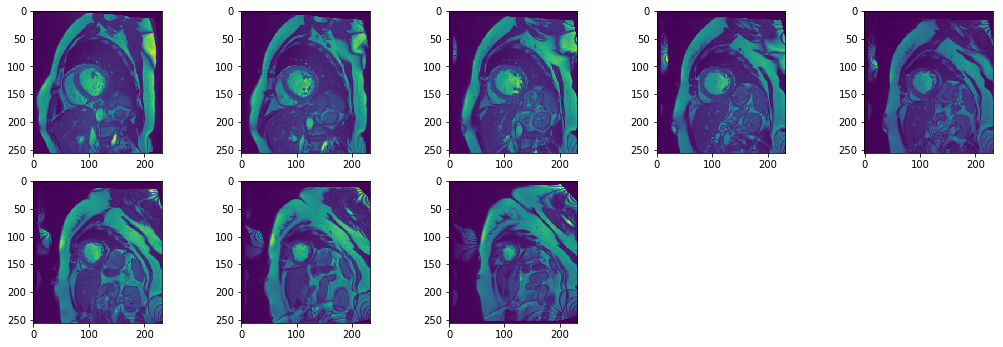

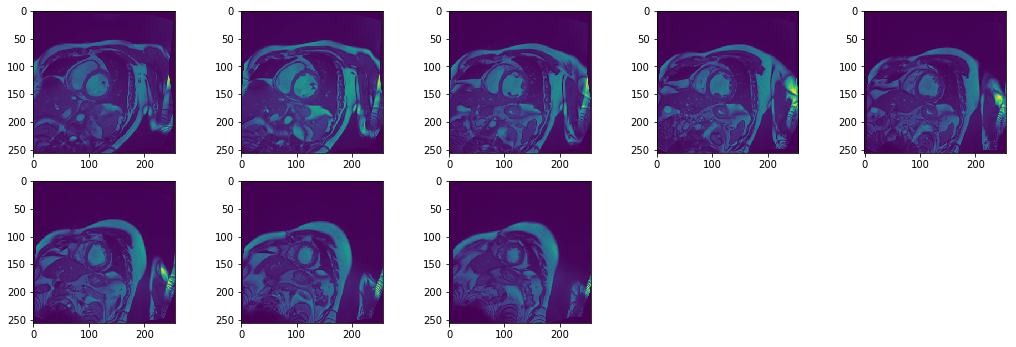

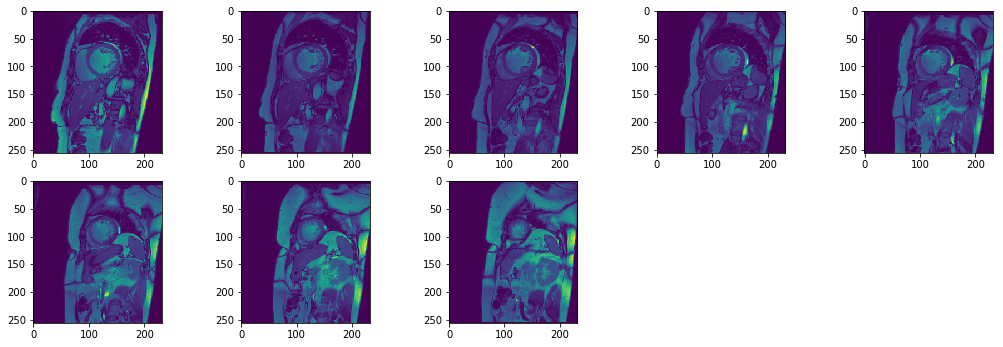

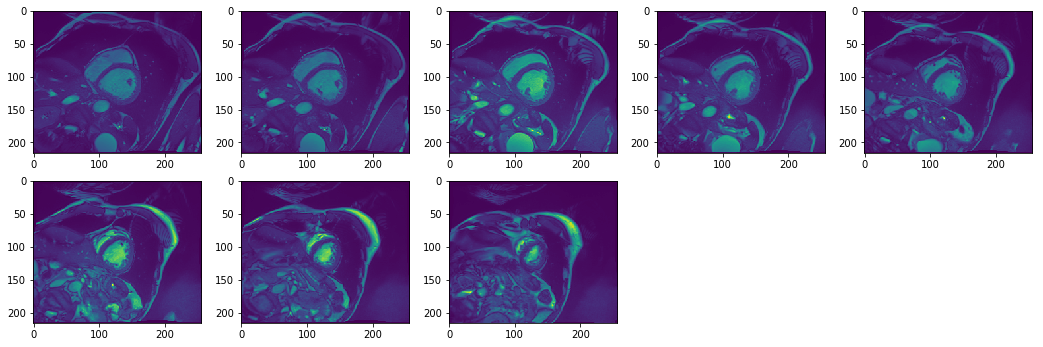

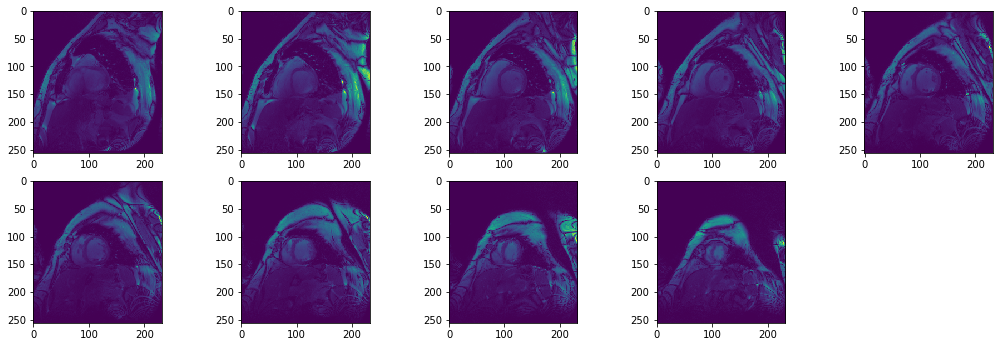

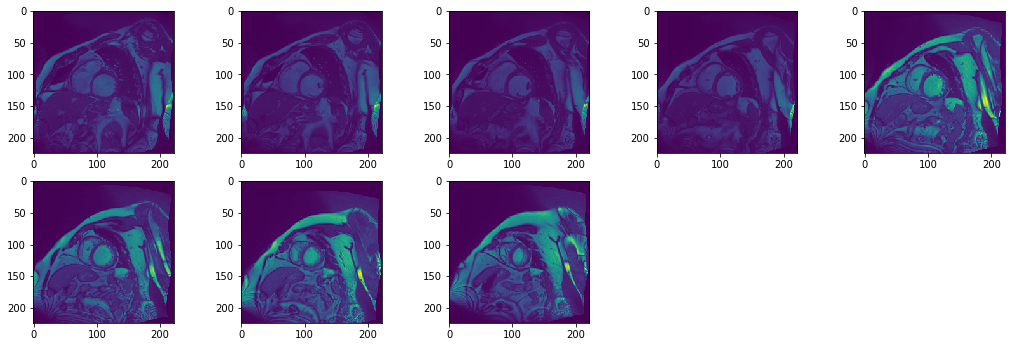

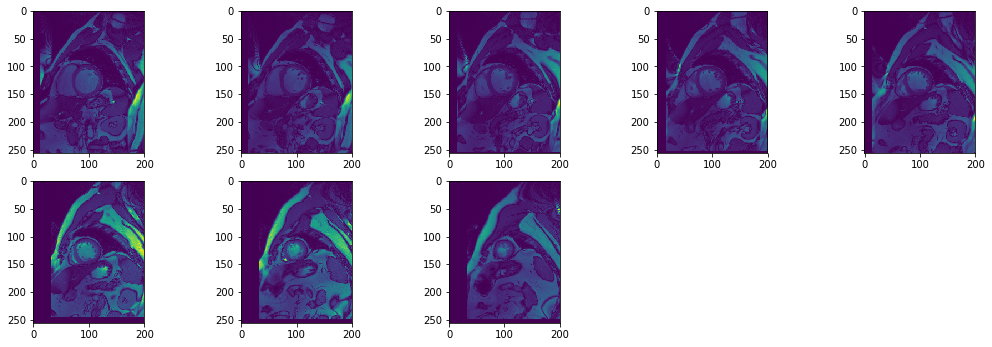

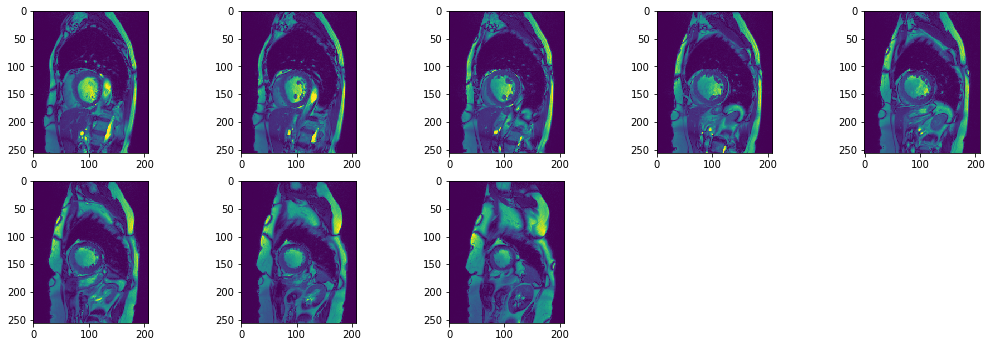

In [27]:
for j in range(1,10):
    fname = "../mri-example-data/training/patient00"+str(j)+"/patient00"+str(j)+"_frame01.nii.gz"
    if os.path.isfile(fname):
        img = sitk.ReadImage(fname)
    img_ = sitk.GetArrayFromImage(img).astype(float)

    plt.figure(figsize=(18,12))
    for i in range(1,np.shape(img_)[0]-1):
        plt.subplot(4,5,i)
        plt.imshow(img_[i])
        #print(np.shape(img_[i]))
    plt.show()

In [39]:
keep_z_spc=True
image = preprocess_image(img, is_seg=(k == "ed_seg" or k == "es_seg"),
                                     spacing_target=(10, 1.25, 1.25), keep_z_spacing=keep_z_spc)

/home/adri/anaconda3/envs/python3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [41]:
print(np.shape(image))
print(type(image))

(10, 320, 270)
<class 'numpy.ndarray'>


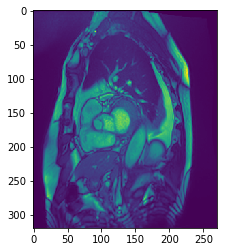

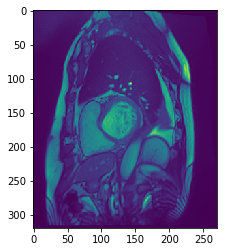

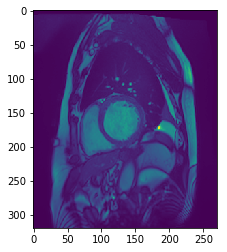

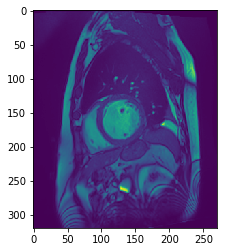

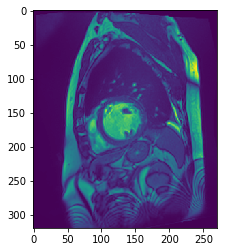

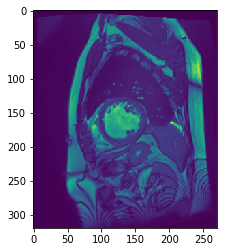

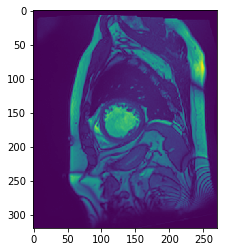

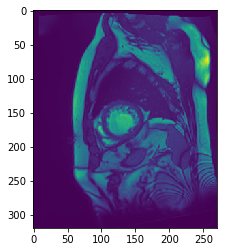

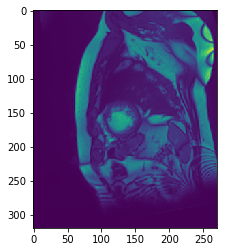

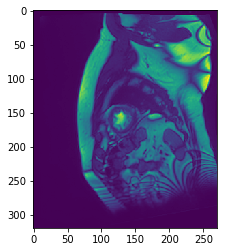

In [42]:
for i in range(np.shape(image)[0]):
    plt.imshow(image[i])
    plt.show()